In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as funcs
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


In [2]:
# test if GPU can use?
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [3]:
# Hyper Parameters
LR = 0.02
batch_size_train = 10
batch_size_valid = 5
# n_iters = 10000
num_epochs = 30
# num_epochs = int(num_epochs)

load the target

In [4]:
train_df = pd.read_csv("train_info.csv")

In [5]:
train_df.head()

,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0079,LA_T_1138215,-,bonafide,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_tra...,0
1,LA_0079,LA_T_1271820,-,bonafide,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_tra...,0
2,LA_0079,LA_T_1272637,-,bonafide,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_tra...,0
3,LA_0079,LA_T_1276960,-,bonafide,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_tra...,0
4,LA_0079,LA_T_1341447,-,bonafide,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_tra...,0


In [6]:
import os
from PIL import Image
import torch
from torchvision import transforms

# Assuming you have defined the 'spectrogram_images_train' folder and transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load Images from a Folder
image_folder_path = 'clean_spectrogram_images_train_part1'
image_paths = [os.path.join(image_folder_path, filename) for filename in os.listdir(image_folder_path)]

# Load Labels
# Assuming 'train_df' has columns 'filename' and 'target'
# skip the "spec_" and ".png"
labels = [train_df[train_df["filename"] == os.path.basename(path)[5:-4]]["target"].values[0] for path in image_paths]

# Apply Transformations
images = [transform(Image.open(path).convert('RGB')) for path in image_paths]

# Create TensorDataset
train_data = torch.utils.data.TensorDataset(torch.stack(images), torch.tensor(labels, dtype=torch.long))

# Define Train and Validation Sizes
train_size = int(0.7 * len(train_data))
valid_size = len(train_data) - train_size

# Split into train and validation sets
train_dataset, valid_dataset = torch.utils.data.random_split(train_data, [train_size, valid_size])

# Create DataLoader for train and validation sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size_valid, shuffle=False)


In [7]:
len(valid_loader)

60

In [8]:
image_paths

['clean_spectrogram_images_train_part1\\spec_LA_T_1000137.png',
 'clean_spectrogram_images_train_part1\\spec_LA_T_1000406.png',
 'clean_spectrogram_images_train_part1\\spec_LA_T_1000648.png',
 'clean_spectrogram_images_train_part1\\spec_LA_T_1000824.png',
 'clean_spectrogram_images_train_part1\\spec_LA_T_1001074.png',
 'clean_spectrogram_images_train_part1\\spec_LA_T_1001114.png',
 'clean_spectrogram_images_train_part1\\spec_LA_T_1001169.png',
 'clean_spectrogram_images_train_part1\\spec_LA_T_1001718.png',
 'clean_spectrogram_images_train_part1\\spec_LA_T_1001871.png',
 'clean_spectrogram_images_train_part1\\spec_LA_T_1002656.png',
 'clean_spectrogram_images_train_part1\\spec_LA_T_1003665.png',
 'clean_spectrogram_images_train_part1\\spec_LA_T_1004407.png',
 'clean_spectrogram_images_train_part1\\spec_LA_T_1004631.png',
 'clean_spectrogram_images_train_part1\\spec_LA_T_1004644.png',
 'clean_spectrogram_images_train_part1\\spec_LA_T_1005349.png',
 'clean_spectrogram_images_train_part1\\

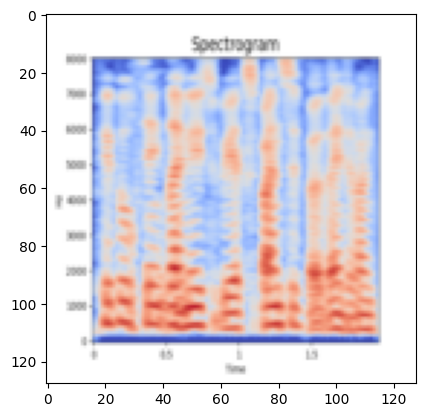

In [9]:
import matplotlib.pyplot as plt
import torchvision

# Assuming 'image_tensor' is your tensor with shape [3, 128, 128]

# Convert the tensor to a NumPy array and permute the dimensions
image_array = images[0].permute(1, 2, 0).numpy()  # Assuming you want to visualize the first image in the batch

# If you are using a batch of images, you might want to loop through them
# for i in range(image_tensor.shape[0]):
#     image_array = image_tensor[i].permute(1, 2, 0).numpy()

# Display the image using Matplotlib
plt.imshow(image_array)
plt.show()


In [10]:
images[0].shape

torch.Size([3, 128, 128])

In [11]:
len(images)

1000

In [12]:
for i, j in zip(image_paths, labels):
    print(i, j)

clean_spectrogram_images_train_part1\spec_LA_T_1000137.png 1
clean_spectrogram_images_train_part1\spec_LA_T_1000406.png 0
clean_spectrogram_images_train_part1\spec_LA_T_1000648.png 1
clean_spectrogram_images_train_part1\spec_LA_T_1000824.png 1
clean_spectrogram_images_train_part1\spec_LA_T_1001074.png 1
clean_spectrogram_images_train_part1\spec_LA_T_1001114.png 1
clean_spectrogram_images_train_part1\spec_LA_T_1001169.png 1
clean_spectrogram_images_train_part1\spec_LA_T_1001718.png 1
clean_spectrogram_images_train_part1\spec_LA_T_1001871.png 1
clean_spectrogram_images_train_part1\spec_LA_T_1002656.png 1
clean_spectrogram_images_train_part1\spec_LA_T_1003665.png 1
clean_spectrogram_images_train_part1\spec_LA_T_1004407.png 1
clean_spectrogram_images_train_part1\spec_LA_T_1004631.png 1
clean_spectrogram_images_train_part1\spec_LA_T_1004644.png 1
clean_spectrogram_images_train_part1\spec_LA_T_1005349.png 1
clean_spectrogram_images_train_part1\spec_LA_T_1006715.png 1
clean_spectrogram_images

CNN model

In [14]:
# define CNN model
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32 ,3) # get 32 x 126 x 126
        self.pool1 = nn.MaxPool2d(2,2) # get 32 x 63 x 63
        self.conv2 = nn.Conv2d(32, 64 ,4) # get 64 x 60 x 60
        self.pool2 = nn.MaxPool2d(2,2) # get 64 x 30 x 30
        self.conv3 = nn.Conv2d(64, 128 ,3) # get 128 x 28 x 28
        self.pool3 = nn.MaxPool2d(2,2) # get 128 x 14 x 14
        # Flatten layers
        self.fc1 = nn.Linear(25088, 512) 
        self.fc2 = nn.Linear(512, 2) 

        # introducing dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = funcs.relu(self.conv1(x)) # apply RelU
        x = self.pool1(x)
        x = self.dropout(x)
        
        x = funcs.relu(self.conv2(x)) # apply RelU
        x = self.pool2(x)
        x = self.dropout(x)
        
        x = funcs.relu(self.conv3(x)) # apply RelU
        x = self.pool3(x)
        x = self.dropout(x)
        
        x = x.view(-1, 25088) # flatten
        x = funcs.relu(self.fc1(x))
        x = self.dropout(x)
        x = (self.fc2(x))
        return x

# set up a model to trainning
model = MyCNN()
print(model)

print('Before saveing: ')
print(model.state_dict())

MyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
Before saveing: 
OrderedDict([('conv1.weight', tensor([[[[ 0.0265, -0.0779, -0.0232],
          [ 0.1455, -0.1338,  0.0390],
          [-0.0135,  0.0052, -0.0753]],

         [[ 0.0360,  0.0245,  0.1130],
          [-0.0119, -0.1296,  0.0972],
          [ 0.1209, -0.1110, -0.1137]],

         [[-0.1646, -0.0835,  0.1280],
          [ 0.1608,  0.1426,  0.0468],
          [ 0.1615,

訓練模型

Epoch [1/30], Train Loss: 0.7022, Train Accuracy: 50.29%, Valid Loss: 0.6927, Valid Accuracy: 50.00%
Epoch [2/30], Train Loss: 0.6931, Train Accuracy: 50.71%, Valid Loss: 0.6921, Valid Accuracy: 50.00%
Epoch [3/30], Train Loss: 0.6888, Train Accuracy: 54.43%, Valid Loss: 0.6884, Valid Accuracy: 63.33%
Epoch [4/30], Train Loss: 0.6745, Train Accuracy: 60.43%, Valid Loss: 0.6755, Valid Accuracy: 69.00%
Epoch [5/30], Train Loss: 0.6205, Train Accuracy: 68.57%, Valid Loss: 0.6271, Valid Accuracy: 68.33%
Epoch [6/30], Train Loss: 0.5592, Train Accuracy: 70.71%, Valid Loss: 0.6095, Valid Accuracy: 68.00%
Epoch [7/30], Train Loss: 0.5518, Train Accuracy: 73.29%, Valid Loss: 0.6697, Valid Accuracy: 60.00%
Epoch [8/30], Train Loss: 0.5329, Train Accuracy: 74.14%, Valid Loss: 0.5933, Valid Accuracy: 69.00%
Epoch [9/30], Train Loss: 0.5212, Train Accuracy: 74.00%, Valid Loss: 0.5525, Valid Accuracy: 72.00%
Epoch [10/30], Train Loss: 0.5123, Train Accuracy: 73.14%, Valid Loss: 0.5566, Valid Accura

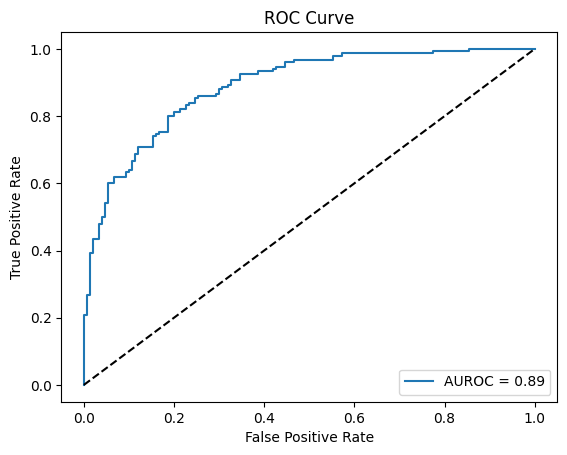

[[141   9]
 [ 60  90]]


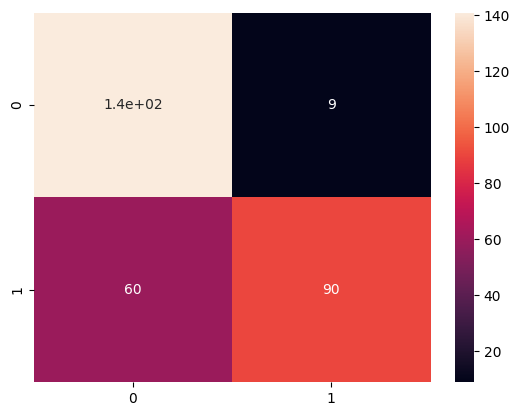

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)   # optimize all cnn parameters

# store loss and acc data
Total_training_loss = []
Total_training_accuracy = []
Total_validation_loss = []
Total_validation_accuracy = []
    
# 訓練模型
def training(model):
    for epoch in range(num_epochs):
        model.train() # 訓練模式
        train_loss = 0.0
        total_train = 0
        correct_train = 0
        for i, (image, label) in  enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                image, label = image.cuda(), label.cuda()
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(image)
            # calculate the batch loss
            loss = criterion(outputs, label)
            
            loss.backward()
            # Update the parameters
            optimizer.step()
            
            # update training loss
            train_loss += loss.item()*image.size(0)
            
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)

            total_train += label.size(0)
            correct_train += (predicted == label).sum().item()
          
        model.eval() # 改變成測試模式
        valid_loss = 0.0
        correct = 0
        total = 0
        all_probs = []
        all_pred = []
        all_label = []
        with torch.no_grad():
            for i, (image, label) in enumerate(valid_loader):
                # move tensors to GPU if CUDA is available
                if train_on_gpu:
                    image, label = image.cuda(), label.cuda()

                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(image)
                # calculate the batch loss
                loss =criterion(output, label)
                # update training loss
                valid_loss += loss.item()*image.size(0)

                probs = torch.nn.functional.softmax(output, dim=1)
                _, predicted = torch.max(probs, 1)

                # Extract the probabilities for class 1 (positive class)
                probs_class_1 = np.array(probs)[:, 1] # for draw the roc

                all_probs.extend(probs_class_1)
                all_pred.extend(predicted.cpu().numpy())
                all_label.extend(label.cpu().numpy())
                total += label.size(0)
                correct += (predicted == label).sum().item()

            # 計算每個樣本的平均損失
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)
            Total_training_loss.append(train_loss)
            Total_validation_loss.append(valid_loss)
            
        # 計算準確率
        accuracy_train = 100 * correct_train / total_train
        accuracy_valid = 100 * correct / total
        Total_training_accuracy.append(accuracy_train)
        Total_validation_accuracy.append(accuracy_valid)
        print(f'Epoch [{epoch+1}/{num_epochs:d}], Train Loss: {train_loss:.4f}, Train Accuracy: {accuracy_train:.2f}%, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {accuracy_valid:.2f}%')

    # 計算 AUROC
    roc_auc = roc_auc_score(all_label, all_probs)
        
    # 繪製 ROC 曲線
    fpr, tpr, _ = roc_curve(all_label, all_probs)
    plt.plot(fpr, tpr, label='AUROC = {:.2f}'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()     
        
    # confusion_matrix
    cm = confusion_matrix(all_label, all_pred)
    print(cm)
    sn.heatmap(cm, annot=True)

# Start training
training(model)

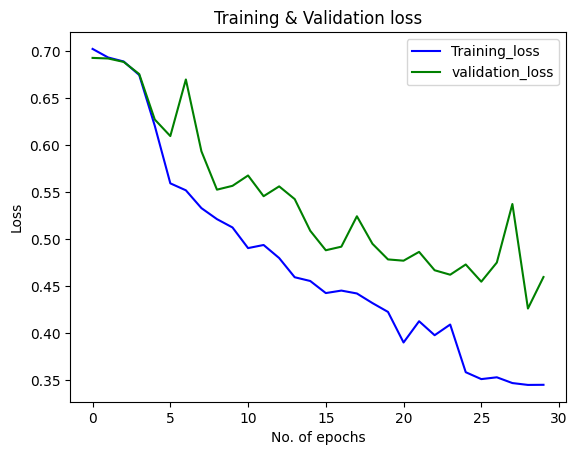

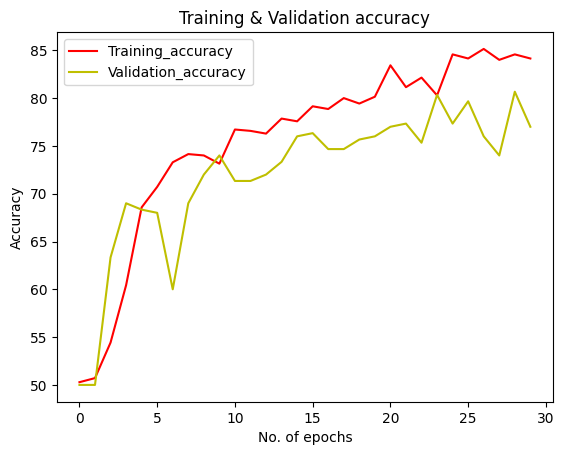

In [18]:
# visualization the loss and accuracy
plt.plot(range(num_epochs), Total_training_loss, 'b-', label='Training_loss')
plt.plot(range(num_epochs), Total_validation_loss, 'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(range(num_epochs), Total_training_accuracy, 'r-', label='Training_accuracy')
plt.plot(range(num_epochs), Total_validation_accuracy, 'y-', label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('No. of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:

c=0
d=0
for i in labels:
    if i == 0:
        c += 1
    else:
        d += 1

In [16]:
c,d

(500, 500)

### Save weight

In [19]:
torch.save(model.state_dict(), 'model1-2.h5')

### **預測**測試集

load model weight

In [20]:
model = MyCNN()
# load the model's weight and bias
model.load_state_dict(torch.load('model1-2.h5'))
model.eval() # for predict

MyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

存入測試檔

In [21]:
# Assuming you have defined the 'spectrogram_images_train' folder and transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load Images from a Folder
image_folder_path = 'clean_spectrogram_images_train_for_test'
image_paths = [os.path.join(image_folder_path, filename) for filename in os.listdir(image_folder_path)]

# Load Labels
# Assuming 'train_df' has columns 'filename' and 'target'
# skip the "spec_" and ".png"
labels = [train_df[train_df["filename"] == os.path.basename(path)[5:-4]]["target"].values[0] for path in image_paths]

# Apply Transformations and convert to tensors
images = [transform(Image.open(path).convert('RGB')) for path in image_paths]

# it is used to convert the list of individual image tensors into a single tensor.
tensor_images = torch.stack(images)  # Convert the list of tensors to a single tensor

Final_test_data = tensor_images.type(torch.float32)


In [22]:
Final_test_data[0].shape

torch.Size([3, 128, 128])

In [23]:
def testing(model, data, labels):
    predict_result = model(data)
    probs = torch.nn.functional.softmax(predict_result, dim=1)
    _, predicted = torch.max(probs, 1) # get the predicted classes by finding the index of the maximum value along dimension 1. 
    # Convert labels to a tensor if they are not already
    labels = torch.tensor(labels).clone().detach()

    total = len(labels)
    correct = (predicted == labels).sum().item()

    print(f'Test data accuracy: {(correct / total) * 100 :.2f}%')

testing(model, Final_test_data, labels)

Test data accuracy: 75.40%
